In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir(r'-----')

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv(r'pulsar_stars.csv')

In [4]:
names = [' Mean of the integrated profile', ' Mean of the DM-SNR curve', ' Standard deviation of the DM-SNR curve', ' Skewness of the DM-SNR curve']
for name in names:
    df[name] = (df[name] - np.mean(df[name]))/np.std(df[name])

In [5]:
X = df[[' Mean of the integrated profile',
       ' Standard deviation of the integrated profile',
       ' Excess kurtosis of the integrated profile',
       ' Skewness of the integrated profile', ' Mean of the DM-SNR curve',
       ' Standard deviation of the DM-SNR curve',
       ' Excess kurtosis of the DM-SNR curve', ' Skewness of the DM-SNR curve']].values
Y = df['target_class'].values
Y = Y.reshape(-1, 1)

In [6]:
from sklearn.model_selection import train_test_split
x, xt, y, yt = train_test_split(X, Y, test_size = 0.05, random_state = 37)
x, xt, y, yt = x.T, xt.T, y.T, yt.T

In [7]:
def iniparams(layer_dims):
    params = {}
    np.random.seed(1)
    for l in range(1, len(layer_dims)):
        params['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])*np.sqrt(2/layer_dims[l - 1])
        params['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return params

In [8]:
def linearfwd(W, A, b):
    Z = np.dot(W, A) + b
    cache = (W, A, b)
    return Z, cache

In [9]:
def relu(Z):
    return np.maximum(0, Z), Z

In [10]:
def sigmoid(Z):
    return 1/(1 + np.exp(-Z)), Z

In [11]:
def fwdactivation(W, A_prev, b, activation):
    if activation == 'relu':
        Z, linear_cache = linearfwd(W, A_prev, b)
        A, activation_cache = relu(Z)
    elif activation == 'sigmoid':
        Z, linear_cache = linearfwd(W, A_prev, b)
        A, activation_cache = sigmoid(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

In [48]:
def fwdmodel(x, params, keep_prob):
    caches = []
    Ds = []
    A = x
    L = len(params)//2
    for l in range(1, L):
        A_prev = A
        A, cache = fwdactivation(params['W' + str(l)], A_prev, params['b' + str(l)], 'relu')
        D = np.random.rand(A.shape[0], A.shape[1])
        D = D < keep_prob
        A = A*D
        A = A/keep_prob
        Ds.append(D)
        caches.append(cache)
    AL, cache = fwdactivation(params['W' + str(L)], A, params['b' + str(L)], 'sigmoid')
    caches.append(cache)
    return AL, caches, Ds

In [49]:
def J(AL, y):
    return -np.sum(np.multiply(np.log(AL), y) + np.multiply(np.log(1 - AL), (1 - y)))/(2*y.shape[1])

In [50]:
def linearbkwd(dZ, cache):
    W, A_prev, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T)/m
    dA_prev = np.dot(W.T, dZ)
    db = np.sum(dZ, axis = 1, keepdims = True)/m
    return dW, dA_prev, db

In [51]:
def sigmoidbkwd(dA, cache):
    Z = cache
    s = 1/(1 + np.exp(-Z))
    dZ = dA*s*(1 - s)
    return dZ

In [52]:
def relubkwd(dA, cache):
    Z = cache
    dZ = np.array(dA, copy = True)
    dZ[Z < 0] = 0
    return dZ

In [53]:
def bkwdactivation(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == 'sigmoid':
        dZ = sigmoidbkwd(dA, activation_cache)
        dW, dA_prev, db = linearbkwd(dZ, linear_cache)
    elif activation == 'relu':
        dZ = relubkwd(dA, activation_cache)
        dW, dA_prev, db = linearbkwd(dZ, linear_cache)
    return dW, dA_prev, db

In [71]:
def bkwdmodel(AL, y, cache, Ds, keep_prob):
    grads = {}
    L = len(cache)
    current_cache = cache[L - 1]
    dAL = -(np.divide(y, AL) - np.divide(1 - y,1 - AL))
    grads['dW' + str(L)], grads['dA' + str(L - 1)], grads['db' + str(L)] = bkwdactivation(dAL, current_cache, 'sigmoid')
    grads['dA' + str(L - 1)] = grads['dA' + str(L - 1)]*Ds[L - 2]
    grads['dA' + str(L - 1)] = grads['dA' + str(L - 1)]/keep_prob
    for l in reversed(range(L - 1)):
        current_cache = cache[l]
        grads['dW' + str(l + 1)], grads['dA' + str(l)], grads['db' + str(l + 1)] = bkwdactivation(grads['dA' + str(l + 1)], current_cache, 'relu')
        if l - 1 >= 0:
            grads['dA' + str(l)] = grads['dA' + str(l)]*Ds[l - 1]
            grads['dA' + str(l)] = grads['dA' + str(l)]/keep_prob
    return grads

In [72]:
def optimize(params, grads, alpha):
    L = len(params)//2
    for l in range(1, L + 1):
        params['W' + str(l)] -= alpha*grads['dW' + str(l)]
        params['b' + str(l)] -= alpha*grads['db' + str(l)]
    return params

In [73]:
import matplotlib.pyplot as plt

In [74]:
def model(x, y, layer_dims, alpha, keep_prob, num_iters = 1000):
    costs = []
    params = iniparams(layer_dims)
    for i in range(0, num_iters + 1):
        AL, cache, Ds = fwdmodel(x, params, keep_prob)
        cost = J(AL, y)
        grads = bkwdmodel(AL, y, cache, Ds, keep_prob)
        params = optimize(params, grads, alpha)
        if i%100 == 0:
            costs.append(cost)
            print('The cost after', i, 'iterations is:', cost)
    plt.title('Costs Vs Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Costs')
    plt.plot(costs)
    return params

The cost after 0 iterations is: 0.3463718597063703
The cost after 100 iterations is: 0.13445668685609413
The cost after 200 iterations is: 0.13310571117016587
The cost after 300 iterations is: 0.13218325523940397
The cost after 400 iterations is: 0.1313774789839329
The cost after 500 iterations is: 0.13252210809738935
The cost after 600 iterations is: 0.130843925600365
The cost after 700 iterations is: 0.13108972212612968
The cost after 800 iterations is: 0.12990366858713948
The cost after 900 iterations is: 0.1300957706580994
The cost after 1000 iterations is: 0.13216294034512868


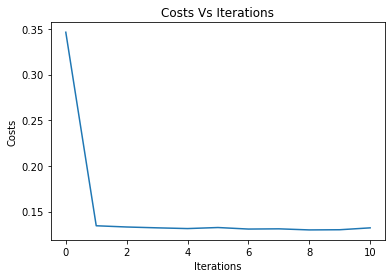

In [88]:
params = model(x, y, [8, 4, 3, 2, 1], 1.2, 0.8)

In [89]:
def predict(x, params):
    AL, cache, _ = fwdmodel(x, params, 0.4)
    predictions = AL >= 0.5
    return AL, predictions

In [90]:
AL, predictions = predict(xt,params)
print ('Accuracy: %d' % float((np.dot(yt,predictions.T) + np.dot(1-yt,1-predictions.T))/float(yt.size)*100)+ '%')
predictions = predictions.astype('int')

Accuracy: 90%
